In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as p
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
from scipy.stats import pearsonr
from scipy.spatial import distance
# from scipy.spatial
from scipy.stats.mstats import gmean
from sklearn.linear_model import LinearRegression
from statsmodels.nonparametric.smoothers_lowess import lowess 
from skmisc.loess import loess
%matplotlib inline
from itertools import combinations
from itertools import chain
from itertools import product
import statsmodels
from sklearn.manifold import TSNE
import umap

from adjustText import adjust_text

from multiprocessing import Pool
import sys
import os
import copy
sns.set_style('white')
sns.set_style('ticks')
sns.set_color_codes()

# fgm_simulation_path = '/Users/grantkinsler/Documents/Stanford/Research/StarryNight/Git/starry-night/Simulations/FGM_simulation_callable.py'
# sys.path.append(os.path.dirname(os.path.expanduser(fgm_simulation_path)))
# from FGM_simulation_callable import simulation, nball_pull, gaussian_fitness

tools_path = '../code/tools.py'
graphs_path = '../code/graphs.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
sys.path.append(os.path.dirname(os.path.expanduser(graphs_path)))
import tools
import graphs
from tools import mutant_colorset
from tools import condition_colorset
from tools import renamed_conditions

In [2]:
fitness_data = p.read_csv('../data/fitness_weighted_allconditions_swapsremoved.csv')

sorted_m3_cols =   ['M3_Batch_23_fitness', '19_fitness', 'M3_Batch_18_fitness',
       'M3_Batch_20_fitness', 'M3_Batch_3_fitness', 'M3_Batch_13_fitness',
       'M3_Batch_6_fitness', '1BB_M3_fitness', 'M3_Batch_21_fitness']

sorted_nonm3_cols = ['1BB_1.4%Gluc_fitness', 'Ferm_44hr_Transfer_fitness',
       '1BB_1%Gly_fitness', '1BB_1.8%Gluc_fitness', '1BB_0.5%Raf_fitness',
       'Geldanamycin8.5uM_fitness', 'Ferm_40hr_Transfer_fitness',
       '1BB_Baffle_fitness', '1.5%_fitness', 'DMSO_fitness',
       '1BB_1%Raf_fitness', '1.7%_fitness', '1.6%_fitness',
       'Ferm_50hr_Transfer_fitness', '1.4%_fitness', '1BB_2ugFlu_fitness',
       'Ferm_54hr_Transfer_fitness', 'Resp_3Day_Transfer_fitness',
       '1BB_17uMGdA_fitness', '1.8%_fitness',
       'Resp_24hr_Transfer_fitness', '1BB_1%EtOH_fitness',
       '1BB_8.5uMGdA_fitness', '1BB_SucRaf_fitness', '2.5%_fitness',
       'Resp_4Day_Transfer_fitness', 'Resp_5Day_Transfer_fitness',
       '1BB_0.2MNaCl_fitness', '1BB_0.2MKCl_fitness',
       '1BB_0.5ugFlu_fitness', 'Ben0.4_fitness', 'Ben2_fitness',
       'Resp_6Day_Transfer_fitness', 'Resp_7Day_Transfer_fitness',
       '1BB_0.5MKCl_fitness', '1BB_0.5MNaCl_fitness']

first_nonsubtle = 16


There are two things we can do to assess how robust the conclusion that the extra 5 components represent real signal.

(1) We can permute the values of all the mutants (and conditions?) in the 5-9 components. If it's true that just having extra dimensions to play with increases predictive power, then there should be an improvement in the new conditions here.

(2) We can change the specific mutants that are in our training and testing sets - if this structure is specific to these mutants, then the signal we see should change. Similarly, we can slightly alter the composition of these sets (slightly more or fewer mutants per gene) to see if this qualitatively changes our results.

## Permuting latent components

4 10 1.0


KeyboardInterrupt: 

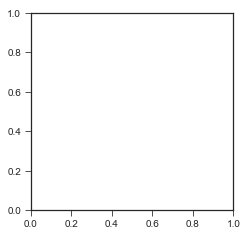

In [5]:
this_data = fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()
this_data = this_data.sort_values('barcode')

datasets = {}


gene_list = ['IRA1_nonsense','GPB2','PDE2','Diploid','ExpNeutral']

n_trials = 4

# param_list = [(4,10),(3,10),(5,10),(4,5),(3,5),(5,5),(4,15),(3,15),(5,15)]
param_list = [(3,10),(4,10),(5,10),(10,10),(3,5),(4,5),(5,5),(10,5),(3,15),(4,15),(5,15),(10,15)]

param_list = [(4,10)]

for m,(max_train,max_test) in enumerate(param_list):
    print(max_train,max_test,((m+1)/(len(param_list))))
    
    plt.figure(figsize=(4*np.ceil(n_trials/2),4*2))
    plt.title(f'{(max_train,max_test)}')
    
    datasets[f'{(max_train,max_test)}'] = {}
    
    for i in range(n_trials):
        ax = plt.subplot(2,np.ceil(n_trials/2),i+1)
#         max_train = 4
#         max_test = 10

        training_bcs, testing_bcs = tools.select_train_test_mutants(this_data,max_train=max_train,max_test=max_test)

        datasets[f'{(max_train,max_test)}'][i] = tools.situate_data(this_data,list(sorted_m3_cols) + list(sorted_nonm3_cols[:first_nonsubtle]),list(sorted_nonm3_cols[first_nonsubtle:]),
                      training_bcs,testing_bcs,gene_list,fixed_mutant_sets=True)


        these_cols = list(sorted_m3_cols) + list(sorted_nonm3_cols[:first_nonsubtle])

        this_fitness = this_data[this_data['barcode'].isin(list(training_bcs)+list(testing_bcs))][these_cols].values

        this_error = this_data[this_data['barcode'].isin(list(training_bcs)+list(testing_bcs))][[col.replace('_fitness','_error') for col in these_cols ]].values

        tools.svd_noise_comparison_figure(ax,this_fitness,this_error,1000,yscale='log')

#     plt.savefig('')


([<matplotlib.axis.XTick at 0x188dfb5c0>,
 <a list of 12 Text xticklabel objects>)

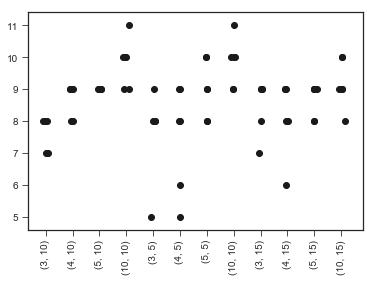

In [116]:
plt.figure()

for m,(max_train,max_test) in enumerate(param_list):
    for i in range(n_trials):
    
        model = datasets[f'{(max_train,max_test)}'][i]['CV_best_rank_index']
        
        plt.scatter(tools.jitter_point(m,0.05),model+1,color='k')
    
plt.xticks(range(len(param_list)),[str(item) for item in param_list],rotation=90)
    
    

([<matplotlib.axis.XTick at 0x1235e8278>,
 <a list of 12 Text xticklabel objects>)

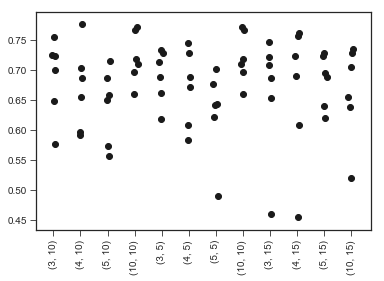

In [115]:
plt.figure()

for m,(max_train,max_test) in enumerate(param_list):
    for i in range(n_trials):
        
        dataset = datasets[f'{(max_train,max_test)}'][i]
     
        all_guesses = dataset['CV_all_guesses']
        both_old = dataset['both_old']
        dhats = dataset['dhats']
        this_fitness  = dataset['this_fitness']
        train  = dataset['train']
        test = dataset['test']
        both_new = dataset['both_new']
        guesses = dataset['guesses']
        model = dataset['CV_best_rank_index']
        test_conditions  = dataset['test_conditions']


        types = this_data[this_data['barcode'].isin(dataset['testing_bcs'])]['mutation_type'].values

        new_mut_locs = dataset['mut_locs'][model][test[1]]

        old_cond_locs = dataset['cond_locs'][model][train[0]]

        new_cond_locs = dataset['cond_locs'][model][test[0]]

        these_sigmas = dataset['dimension_weights'][model]
        these_sigmas = these_sigmas[:model+1,:model+1]

        nonsubtle_fit = tools.var_explained_weighted_by_type(this_fitness[test[1],:][:,test[0]],
                                                                      np.dot(new_mut_locs,np.dot(these_sigmas,new_cond_locs.T)),types)[0]

        plt.scatter(tools.jitter_point(m,0.05),nonsubtle_fit,color='k')
    
plt.xticks(range(len(param_list)),[str(item) for item in param_list],rotation=90)
    
    

4 0.6995003277918794
9 0.6907695310957808
4 0.6938394713825398
9 0.6903173952584878
4 0.685114357622292
9 0.7039430790086909
4 0.5375155148999242
9 0.620234789563438
4 0.6875746975962318
9 0.7309455156399587
4 0.6762901634532403
9 0.7090805537247679
4 0.7075126835406851
9 0.7071943399838247
4 0.685257254593292
9 0.7357175487773939
4 0.6795456309336492
9 0.7222714925432252
4 0.5819625903477103
9 0.6385251191592767


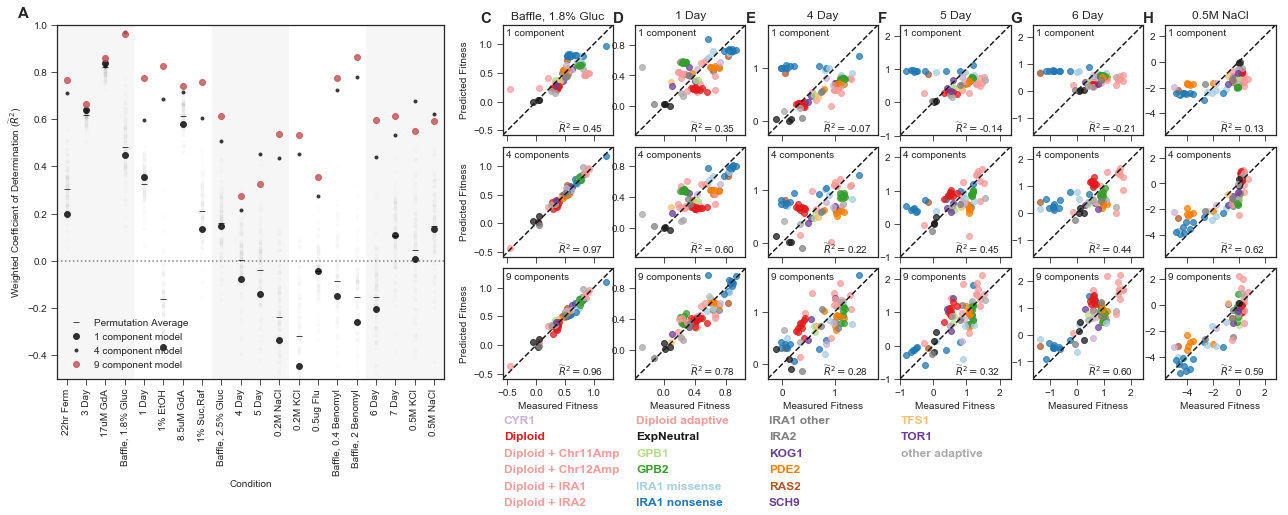

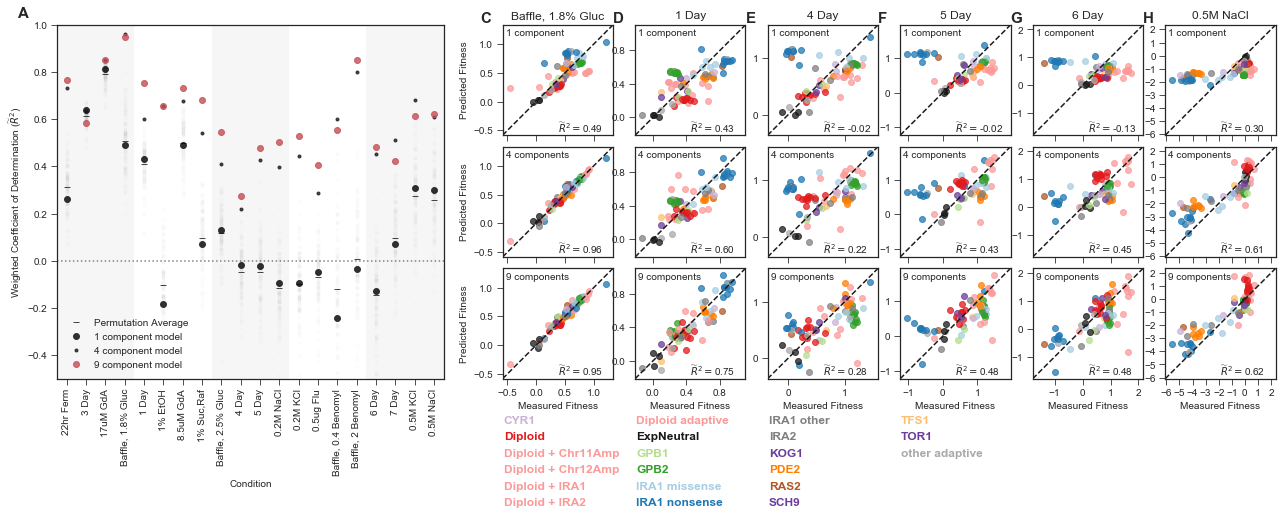

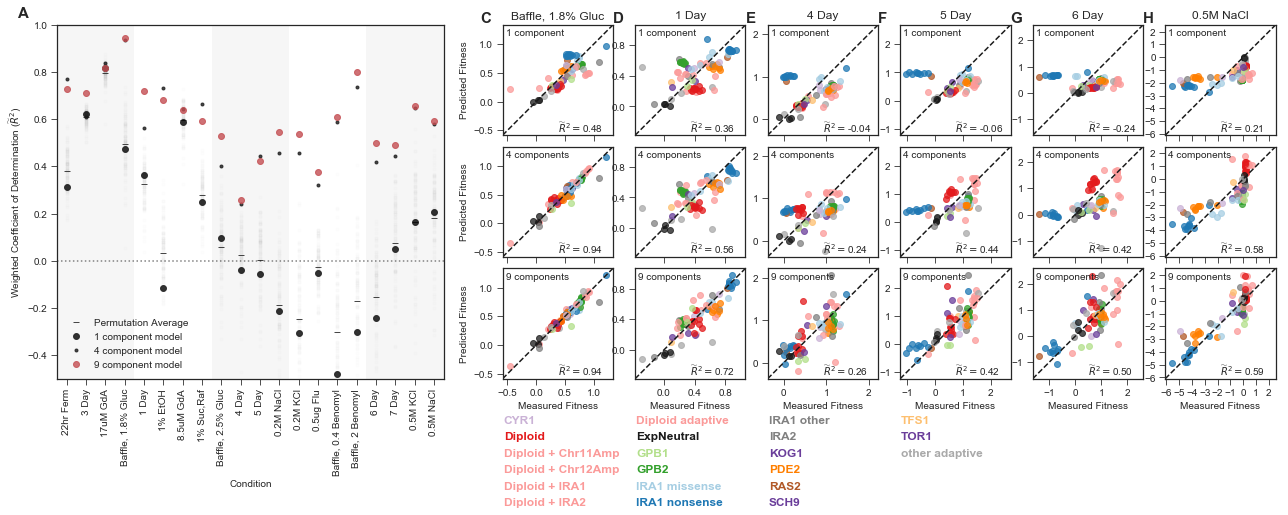

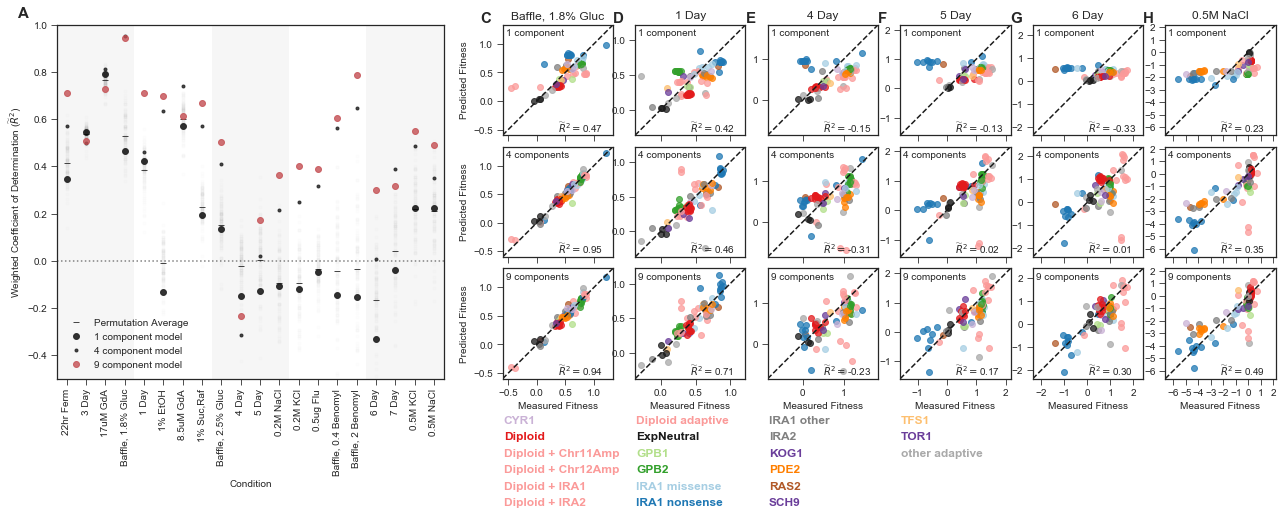

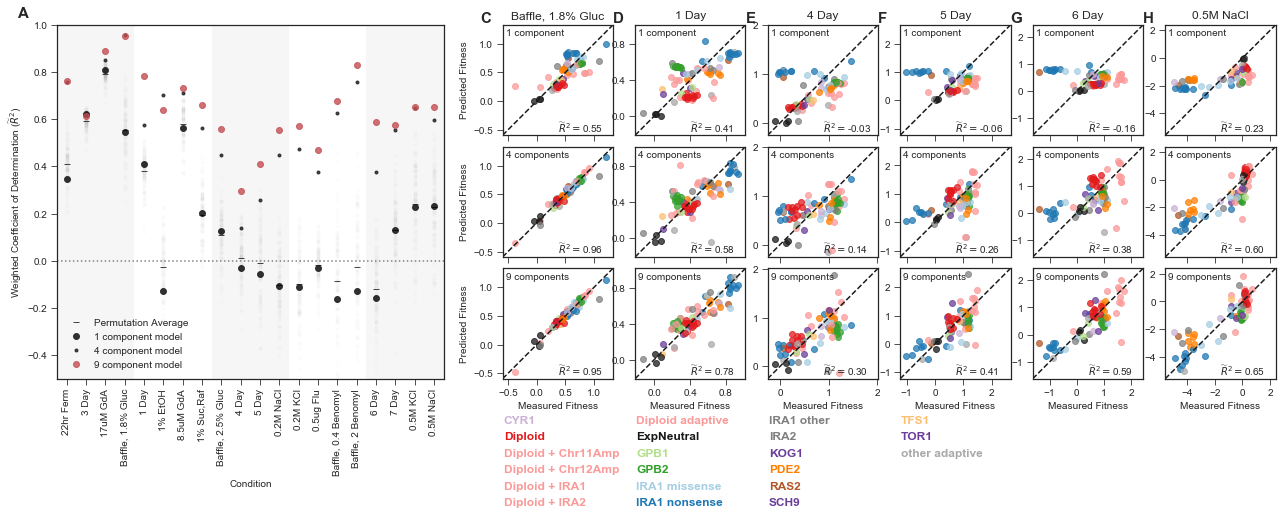

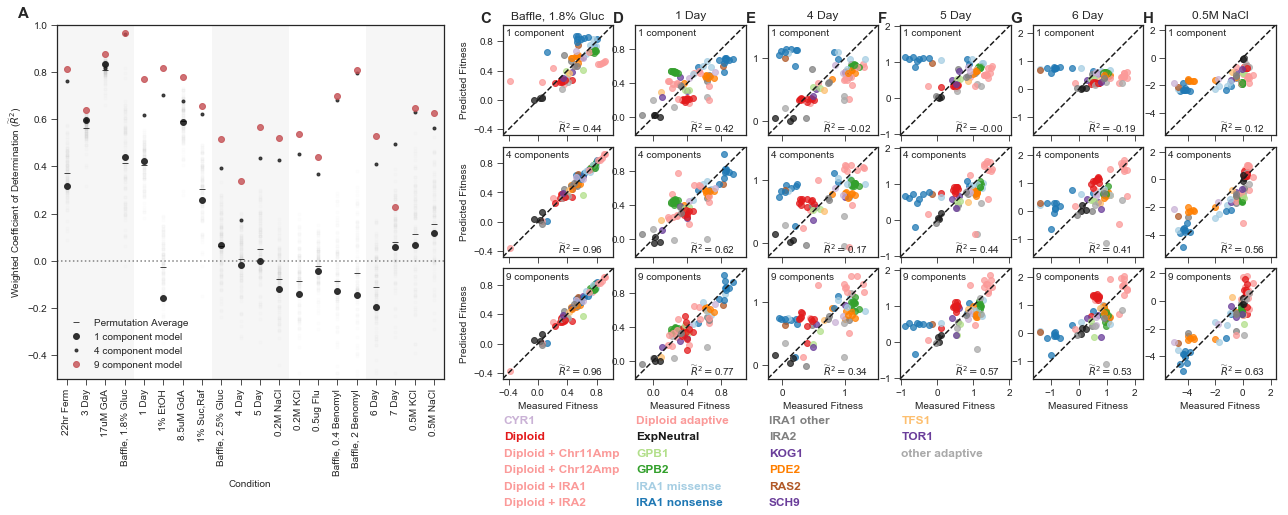

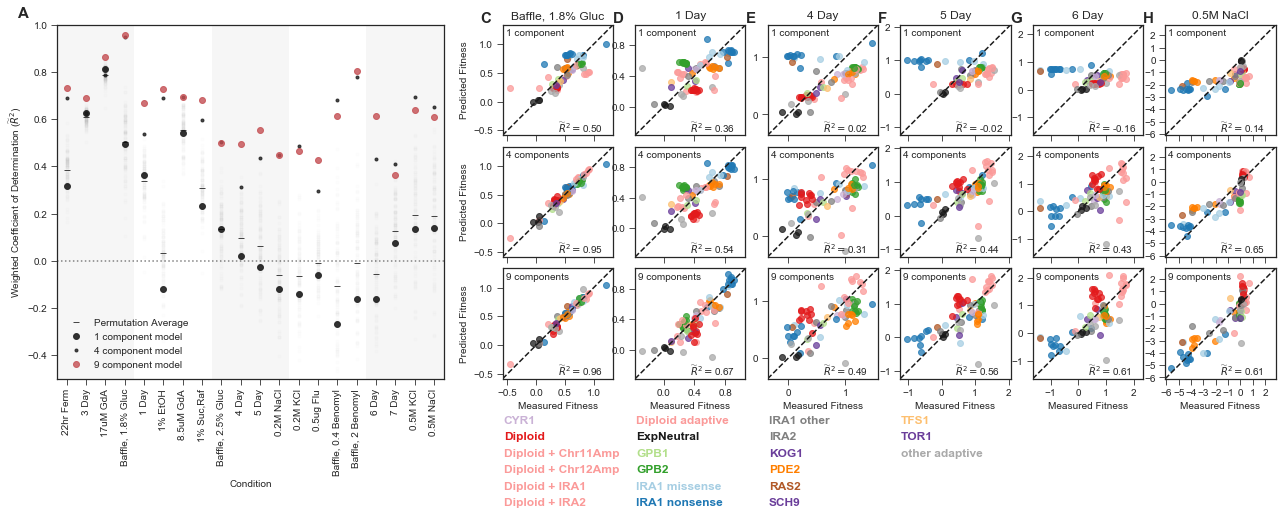

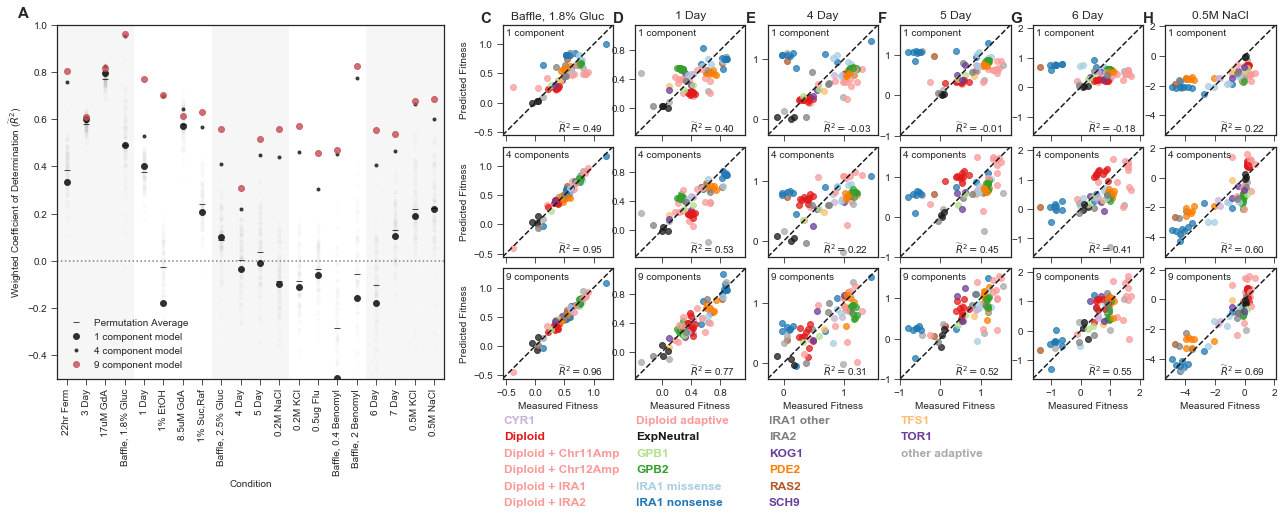

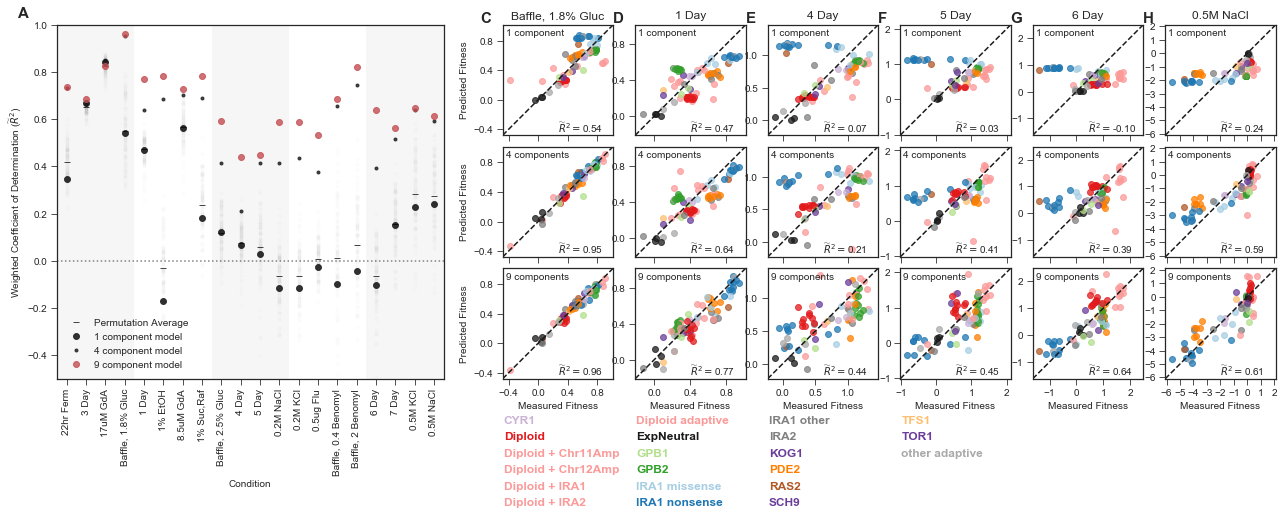

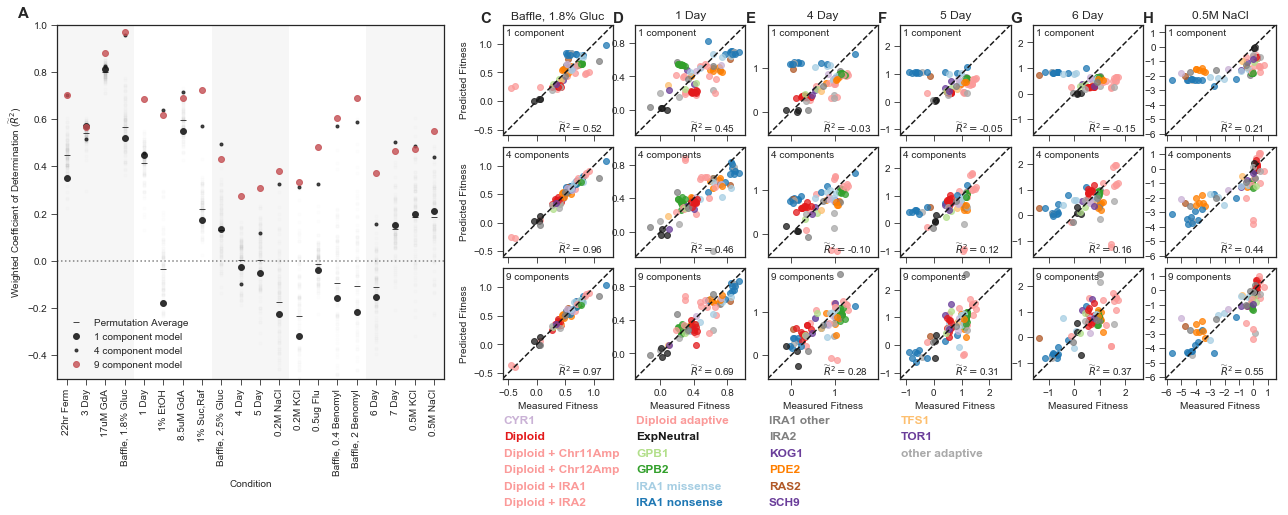

In [10]:
for i in range(n_trials):
#     example_names = ['1.8%','Resp_24hr_Transfer','1BB_1%EtOH','Ben2','1BB_0.5MNaCl']
#     # graphs.Figure4_w_examples(datasets['batch_to_nonbatch_wothers_fixed_mutants'],gene_list,this_data,[col + '_fitness' for col in example_names],model=4)
#     interesting_conditions = ['Resp_24hr_Transfer_fitness','1BB_SucRaf_fitness','2.5%_fitness','Resp_4Day_Transfer_fitness', '1BB_0.5ugFlu_fitness','Resp_6Day_Transfer_fitness']
#     example_names = ['1.8%','Resp_24hr_Transfer','1BB_SucRaf','2.5%','Resp_4Day_Transfer', '1BB_0.5ugFlu','Resp_6Day_Transfer','1BB_0.5MNaCl']
    example_names = ['1.8%','Resp_24hr_Transfer','Resp_4Day_Transfer','Resp_5Day_Transfer','Resp_6Day_Transfer','1BB_0.5MNaCl']
    
    graphs.Figure4_w_examples(datasets[i],gene_list,this_data,[col + '_fitness' for col in example_names],models=[3,8],weighted=True)
# plt.savefig(f'Figure4_with_prediction_examples_unweighted.pdf',bbox_inches='tight')

In [ ]:
this_data = fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()
this_data = this_data.sort_values('barcode')


ns_fits = {}
s_fits = {}

for m,(max_train,max_test) in enumerate(param_list):
    plt.figure(figsize=(4*np.ceil(n_trials/2),4*2))
    plt.suptitle(f'{(max_train,max_test)}')
    
    ns_fits[f'{(max_train,max_test)}'] = {}
    s_fits[f'{(max_train,max_test)}'] = {}
    for i in range(n_trials):
        ax = plt.subplot(2,np.ceil(n_trials/2),i+1)
        
        dataset = datasets[f'{(max_train,max_test)}'][i]
        n_perms = 100
        weighted= True
        ymax = 1.0
        ymin = -1.0

        all_guesses = dataset['CV_all_guesses']
        both_old = dataset['both_old']
        dhats = dataset['dhats']
        this_fitness  = dataset['this_fitness']
        train  = dataset['train']
        test = dataset['test']
        both_new = dataset['both_new']
        guesses = dataset['guesses']
        model = dataset['CV_best_rank_index']
        test_conditions  = dataset['test_conditions']
        
        end = model
        nonsubtle_fits = []
        subtle_fits = []
        overall_subtle = []
        overall_nonsubtle = []
        for model in range(20):
            # this_gene_data = this_data[this_data['barcode'].isin(test_mutant_data)]
            types = this_data[this_data['barcode'].isin(dataset['testing_bcs'])]['mutation_type'].values

            new_mut_locs = dataset['mut_locs'][model][test[1]]

            old_cond_locs = dataset['cond_locs'][model][train[0]]

            new_cond_locs = dataset['cond_locs'][model][test[0]]

            these_sigmas = dataset['dimension_weights'][model]
            these_sigmas = these_sigmas[:model+1,:model+1]

            overall_nonsubtle.append(tools.var_explained_weighted_by_type(this_fitness[test[1],:][:,test[0]],
                                                                          np.dot(new_mut_locs,np.dot(these_sigmas,new_cond_locs.T)),types)[0])

            this_sse = np.asarray([tools.var_explained_weighted_by_type(this_fitness[test[1],test[0][i]],
                                                                          np.dot(new_mut_locs,np.dot(these_sigmas,new_cond_locs.T))[:,i],types)[0] for i in range(new_cond_locs.shape[0])])
            nonsubtle_fits.append(this_sse)
            

            overall_subtle.append(tools.var_explained_weighted_by_type(this_fitness[test[1],:][:,train[0]],
                                                                          np.dot(new_mut_locs,np.dot(these_sigmas,old_cond_locs.T)),types)[0])


            subtle_sse = np.asarray([tools.var_explained_weighted_by_type(this_fitness[test[1],train[0][i]],
                                                                          np.dot(new_mut_locs,np.dot(these_sigmas,old_cond_locs.T))[:,i],types)[0] for i in range(old_cond_locs.shape[0])])


            subtle_fits.append(subtle_sse)
        
        ns_fits[f'{(max_train,max_test)}'][i] = nonsubtle_fits
        s_fits[f'{(max_train,max_test)}'][i] = subtle_fits
#         end = model

        plt.plot([overall_subtle[0]]+list(np.diff(overall_subtle))[:end],'o',markeredgecolor='k',markerfacecolor='None',label='Subtle')
        plt.ylabel('Added Weighted Variance Explained')
        # plt.yscale('log',basey=10)

        for i,item in enumerate([overall_subtle[0]]+list(np.diff(overall_subtle))[:end]):
        #     plt.annotate(xy=(i+0.2,item+0.0*item),s=f'{item*100:.2f}% ({overall_subtle[i]*100:.2f}%)',transform=plt.gca().transAxes)
            plt.annotate(xy=(i+0.2,item-0.1*item),s=f'{item*100:.2f}%',transform=plt.gca().transAxes)

        plt.plot([overall_nonsubtle[0]]+list(np.diff(overall_nonsubtle))[:end],'o',markeredgecolor='r',markerfacecolor='None',label='Strong')
        plt.ylabel('Added Weighted Variance Explained')
        plt.yscale('log',basey=10)
        plt.xticks(range(len(overall_subtle[:end+1])),range(1,len(overall_subtle[:end+1])+1))
        plt.xlabel('Component')

        for i,item in enumerate([overall_nonsubtle[0]]+list(np.diff(overall_nonsubtle))[:end]):
            plt.annotate(xy=(i+0.2,item+0.1*item),s=f'{item*100:.2f}%',transform=plt.gca().transAxes,color='r')


        ymin,ymax = plt.ylim()
        for i,item in enumerate([overall_nonsubtle[0]]+list(np.diff(overall_nonsubtle))[:end]):
            if item < 0:
                plt.annotate(xytext=(i,2*ymin),xy=(i,ymin+0.1*ymin),s=f'{item*100:.2f}%',transform=plt.gca().transAxes,color='r',
                             ha='center',arrowprops=dict(arrowstyle='->',color='r'))
    #             plt.annotate(xytext=(i,2*ymin),xy=(i,ymin+0.1*ymin),s="",transform=plt.gca().transAxes,color='r',
    #                  ha='center',arrowprops=dict(arrowstyle='->',color='r'))

        #     plt.annotate(xy=(i+0.2,item+0.0*item),s=f'{item*100:.2f}% ({overall_subtle[i]*100:.2f}%)',transform=plt.gca().transAxes)

        plt.xlim(-0.5,end+1.5)
#         plt.title('Contribution of components')
        plt.legend()
    

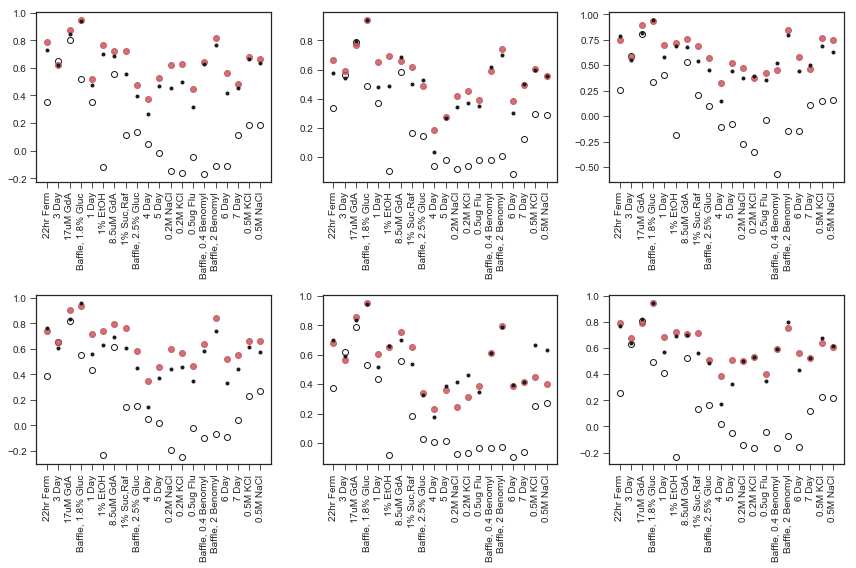

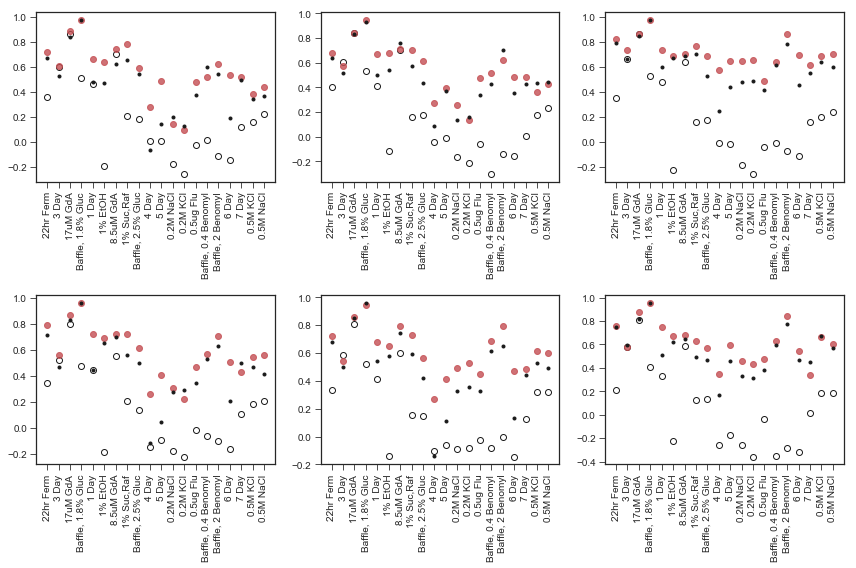

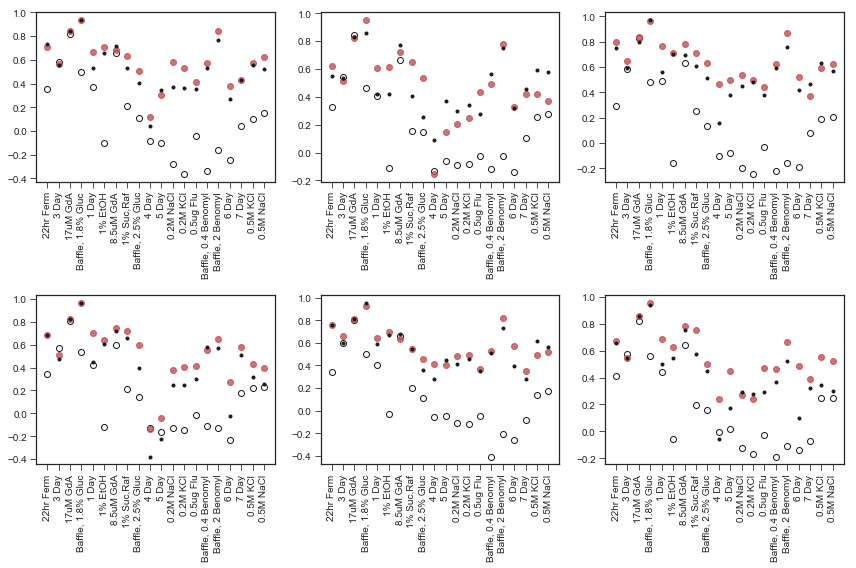

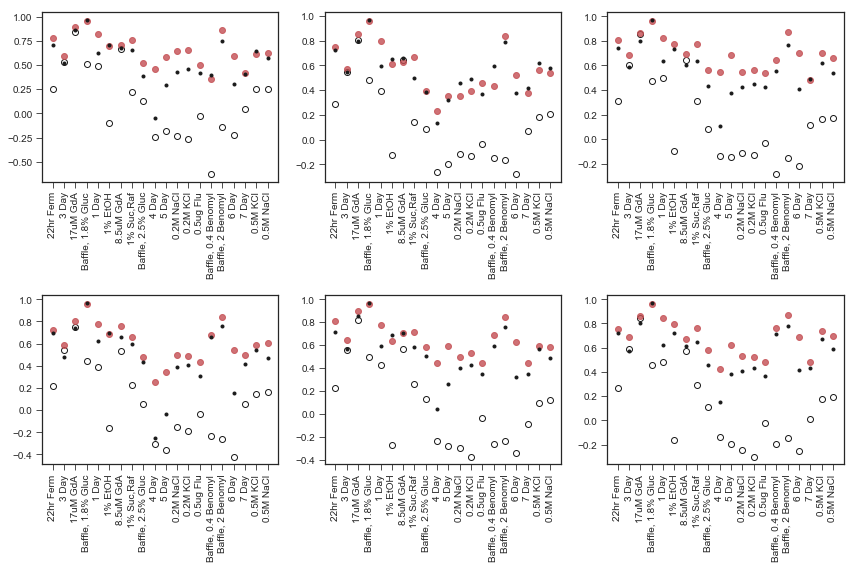

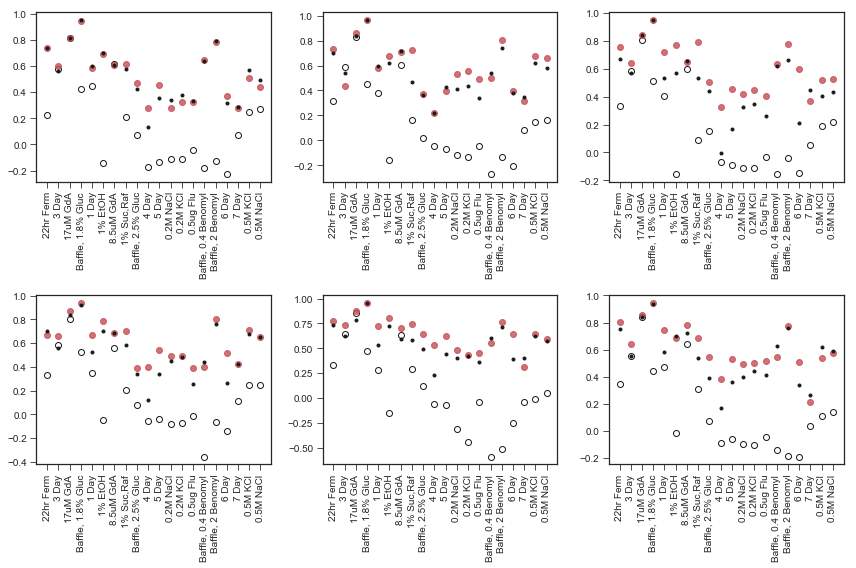

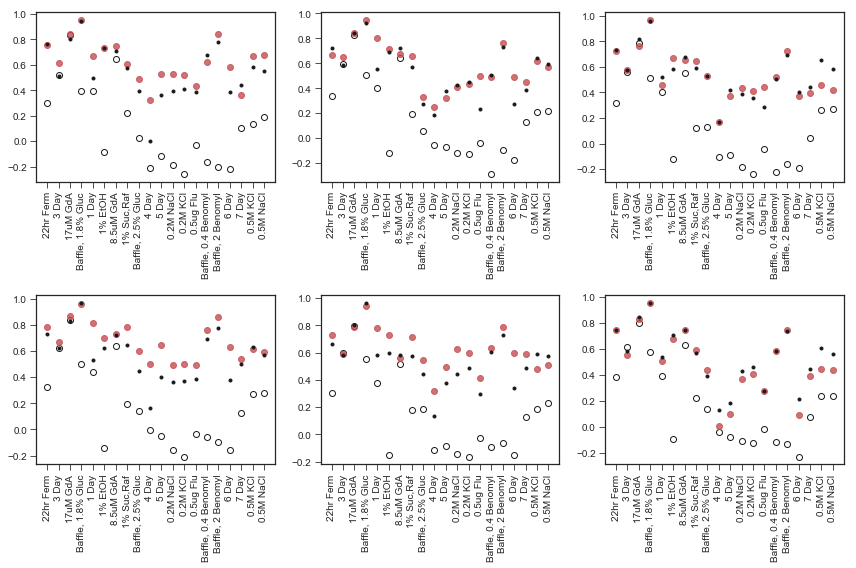

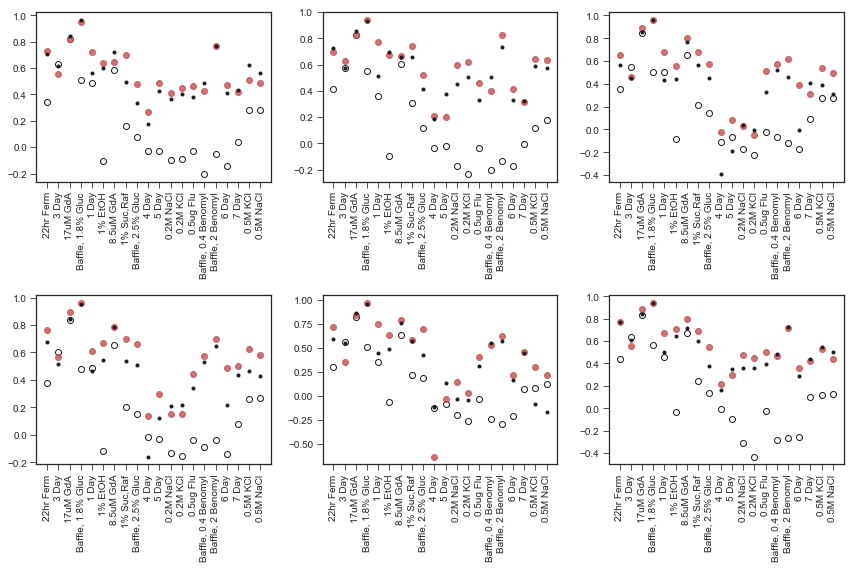

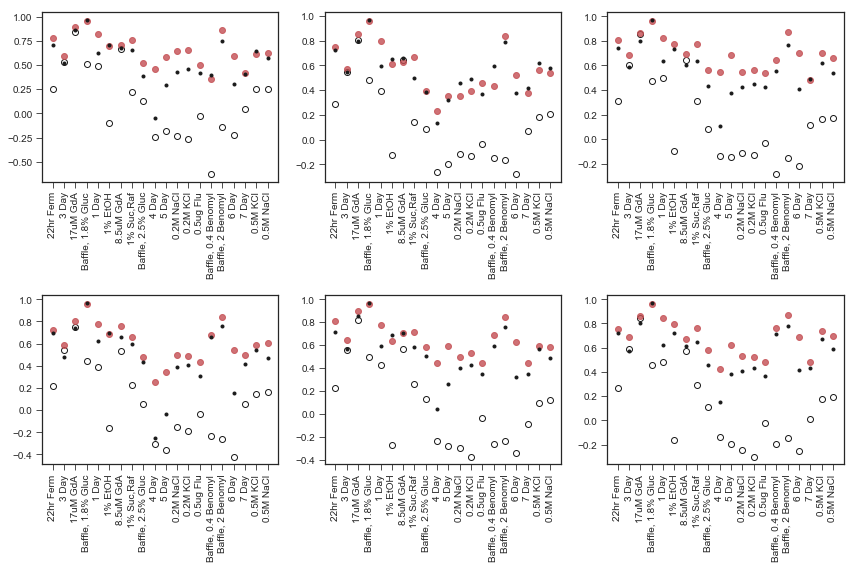

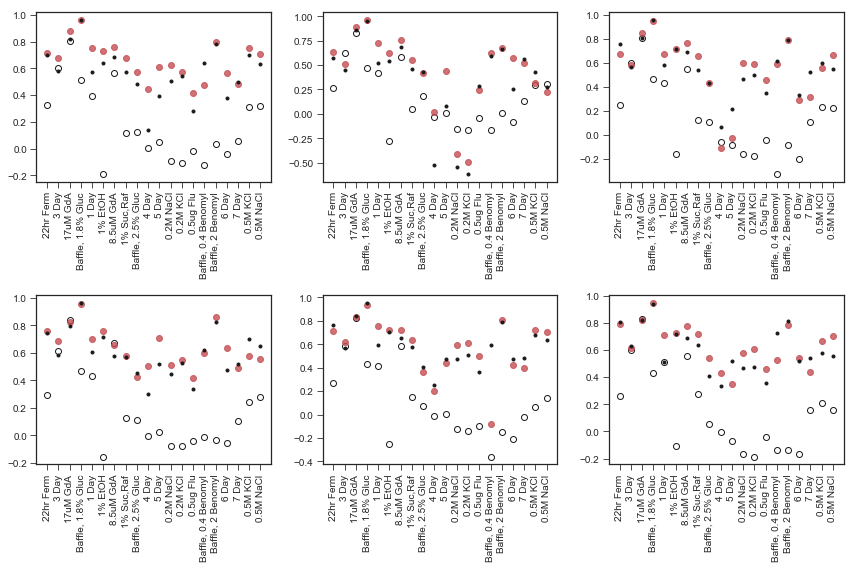

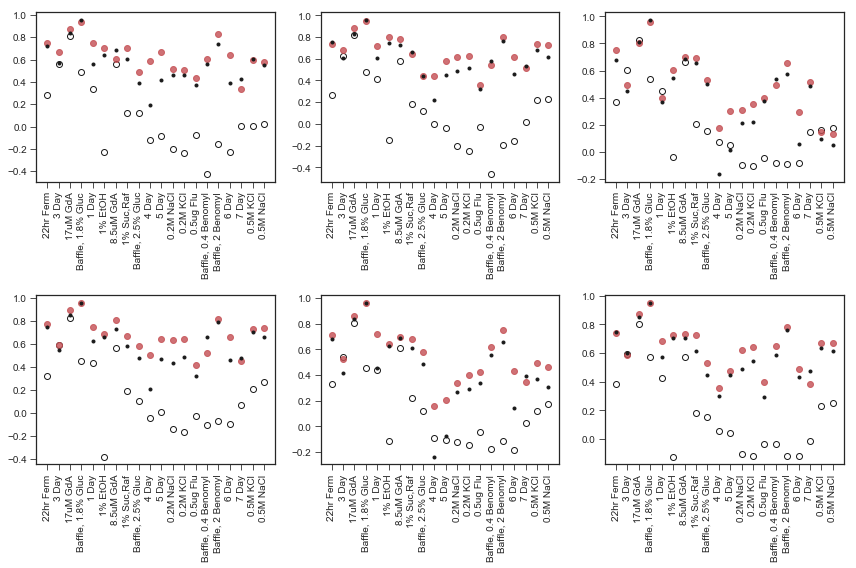

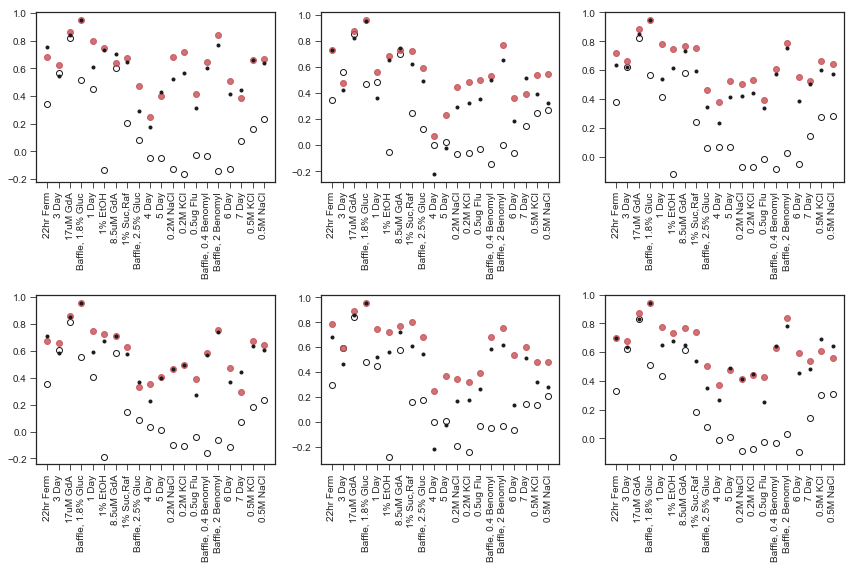

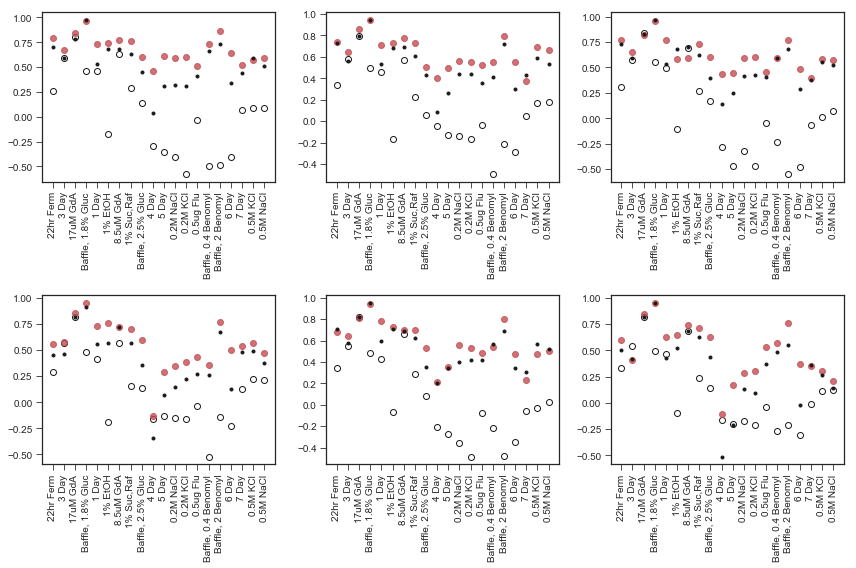

In [118]:
for m,(max_train,max_test) in enumerate(param_list):
    plt.figure(figsize=(4*np.ceil(n_trials/2),4*2))
    
#     ns_fits[f'{(max_train,max_test)}'] = {}
#     s_fits[f'{(max_train,max_test)}'] = {}
    for i in range(n_trials):
        ax = plt.subplot(2,np.ceil(n_trials/2),i+1)
        model = datasets[f'{(max_train,max_test)}'][i]['CV_best_rank_index']
        
        plt.plot(ns_fits[f'{(max_train,max_test)}'][i][0],'ko',markeredgecolor='k',markerfacecolor='None')
        
        plt.plot(ns_fits[f'{(max_train,max_test)}'][i][model],'ro',alpha=0.8)
        
        plt.plot(ns_fits[f'{(max_train,max_test)}'][i][3],'k.')
        
        plt.xticks(range(len(ns_fits[f'{(max_train,max_test)}'][i][3])),[renamed_conditions[col.replace('_fitness','')] for col in sorted_nonm3_cols[first_nonsubtle:]],rotation=90)
        plt.tight_layout()
        

In [ ]:
dataset = datasets['subtle_to_strong_wothers']
n_perms = 100
weighted= True
ymax = 1.0
ymin = -1.0

all_guesses = dataset['CV_all_guesses']
both_old = dataset['both_old']
dhats = dataset['dhats']
this_fitness = dataset['this_fitness']
this_error = dataset['this_error']
train  = dataset['train']
test = dataset['test']
both_new = dataset['both_new']
guesses = dataset['guesses']
model = dataset['CV_best_rank_index']
test_conditions  = dataset['test_conditions']
train_conditions = dataset['train_conditions']


nonsubtle_fits = []
subtle_fits = []
overall_subtle = []
overall_nonsubtle = []

model_list = [0,]
    model_colors = ['k','lightgray','r']

    all_conditions = train_conditions + test_conditions


    all_bcs = sorted(list(dataset['training_bcs'])+list(dataset['testing_bcs']))

    testing_bcs = list(dataset['testing_bcs'])

    these_bcs = testing_bcs

    these_genes = this_data[this_data['barcode'].isin(these_bcs)]['mutation_type'].values
    gene_bc = np.asarray([f'{gene} ({bc})' for bc,gene in zip(these_bcs,these_genes)])
    gene_bc = np.asarray([f'{gene}' for bc,gene in zip(these_bcs,these_genes)])


    for condition in interesting_conditions:

        condition_loc = np.where(np.isin(all_conditions,condition))[0][0]

        this_f = this_fitness[np.where(np.isin(all_bcs,these_bcs))[0]]
        this_e = this_error[np.where(np.isin(all_bcs,these_bcs))[0]]



        fits = []

        for m,model in enumerate(model_list):

            new_mut_locs = dataset['mut_locs'][model][test[1]]
            old_cond_locs = dataset['cond_locs'][model][train[0]]
            new_cond_locs = dataset['cond_locs'][model][test[0]]   
            these_sigmas = dataset['dimension_weights'][model]
            these_sigmas = these_sigmas[:model+1,:model+1]

            new_fits = [np.abs(np.dot(new_mut_locs,np.dot(these_sigmas,new_cond_locs.T))[bc,condition_loc-old_cond_locs.shape[0]]-this_f[bc,condition_loc])/this_e[bc,condition_loc] for bc in range(len(these_bcs))]

            sorting  = np.argsort(new_fits)

            fits.append(new_fits)

        data = (np.asarray(fits[1])-np.asarray(fits[2]))/(np.asarray(fits[1]))
        data = (np.asarray(fits[1])-np.asarray(fits[2]))
        data = np.asarray(fits[2])-np.asarray(fits[1])
        sorting = np.argsort(data)
        data = data[sorting]
        sorted_genes = these_genes[sorting]

        plt.figure(figsize=(12,6))
        plt.subplot(211)
        plt.title(renamed_conditions[condition.replace('_fitness','')])

        for m,model in enumerate(model_list):
            sorted_fits = np.asarray(fits[m])[sorting]
            plt.scatter(range(len(sorted_fits)),sorted_fits,marker='o',color=model_colors[m],label=f'{model+1} components')

        plt.xticks([])
        plt.legend()

        plt.xlim(-1,len(these_bcs))
        ymin,ymax = plt.ylim()

        for i in range(int(np.ceil(len(these_bcs)/4))):
            if (i % 2) == 0:
                # print(i)
                rect = matplotlib.patches.Rectangle((0+4*i-0.5,ymin),4,ymax-ymin,
                                                linewidth=0,edgecolor='gray',facecolor='gray',alpha=0.07)

                plt.gca().add_patch(rect)

        plt.subplot(212)

        plt.scatter(range(len(data)),data,marker='o',color=[mutant_colorset[gene] for gene in sorted_genes])


        plt.axhline(0,color='k',linestyle=':')
        plt.xticks(range(len(these_bcs)),gene_bc[sorting],rotation=90)

        ymin = -1.0
        ymax = 4.0
        plt.ylabel(f'Improvement from {model_list[1]+1} to {model_list[2]+1}')

        plt.xlim(-1,len(these_bcs))
        ymin,ymax = plt.ylim()

        for i in range(int(np.ceil(len(these_bcs)/4))):
            if (i % 2) == 0:
                # print(i)
                rect = matplotlib.patches.Rectangle((0+4*i-0.5,ymin),4,ymax-ymin,
                                                linewidth=0,edgecolor='gray',facecolor='gray',alpha=0.07)

                plt.gca().add_patch(rect)

    #     toohigh = np.where(data>ymax)[0]
    #     low_counter = 0
    #     for entry in toohigh:
    #         plt.annotate("", xy=(entry, ymax), xytext=(entry, ymax-0.1*(ymax-ymin)),arrowprops=dict(arrowstyle="->",lw=1.5,color=mutant_colorset[sorted_genes[entry]]))
        plt.savefig(f'improvement_by_mutant_{condition}_{model_list[1]+1}_to_{model_list[2]+1}.pdf',bbox_inches='tight')

In [107]:
def SVD_predictions_train_test_weighted(data,train,test,
                                        permuted_mutants=False,permuted_conditions=False,
                                        mse=False,by_condition=False,by_mutant=False,error=None,likelihood=False,
                                        weighted_by_type=True,types=None):
    
    """ 
    Bi-cross validation using multiple folds of data matrix. 

    Method from Owen and Perry 2009.

    For each fold, we have the following data matrix:

                        "new conditions"  "old conditions"
    "new mutants"              A                  B
    "old mutants"              C                  D

    We first perform SVD on the D sub-matrix (using only old mutants and old conditions).
    For every pseudo inverse rank k approximation of D (denoted by D_k^+), we matrix multiply B * D_k^+ * C which gives the best estimate for A from the D_k approximation.

    We then evaluate prediction ability use the residual (eqn 3.3 from Owen and Perry 2009):

        A - B * D_k^+ * C 

    """

    train_c = train[0]
    train_m = train[1]

    test_c = test[0]
    test_m = test[1]

    this_data = data
    
    assert len(train_m) + len(test_m) == this_data.shape[0]
    assert len(train_c) + len(test_c) == this_data.shape[1]

    max_rank = min([len(train_c),len(train_m)])

    fits_by_condition = []
    fits_by_mutant = []
    mean_fits =[]

    if permuted_mutants and permuted_conditions:
        this_data = copy.copy(data)
        this_data[train_m,train_c] = np.random.permutation(this_data[train_m,train_c].ravel()).reshape(len(train_m),len(train_c))
        subset = this_data[np.repeat(train_m,len(train_c)),np.tile(train_c,len(train_m))].ravel()

    elif permuted_mutants:
        this_data = copy.copy(data)
        for mut in train_m:
            this_data[mut,train_c] = np.random.permutation(this_data[mut,train_c])

    elif permuted_conditions:

        this_data = np.swapaxes(copy.copy(data),0,1)
        for cond in train_c:
            this_data[cond,train_m] = np.random.permutation(this_data[cond,train_m])
        this_data = np.swapaxes(this_data,0,1)

    else:
        this_data = copy.copy(data)
        
    if weighted_by_type:
        train_count,train_inv_count = count_matrix(types[train_m],this_data[train_m,:])
        test_count,test_inv_count = count_matrix(types[test_m],this_data[test_m,:])
        
        order = np.argsort(np.concatenate((train_m,test_m)))
        
        all_count = np.concatenate((train_count,test_count))[order]
        all_inv_count = np.concatenate((train_inv_count,test_inv_count))[order]
        
        weighted_data = np.multiply(all_inv_count,this_data)
    else:
        train_count = np.ones(this_data[train_m,:].shape)
        train_inv_count = np.ones(this_data[train_m,:].shape)
        test_count = np.ones(this_data[test_m,:].shape)
        test_inv_count = np.ones(this_data[test_m,:].shape)
        
        order = np.argsort(np.concatenate((train_m,test_m)))
        
        all_count = np.concatenate((train_count,test_count))[order]
        all_inv_count = np.concatenate((train_inv_count,test_inv_count))[order]
        
        weighted_data = copy.copy(this_data)
        
    both_old = weighted_data[np.repeat(train_m,len(train_c)),np.tile(train_c,len(train_m))].reshape(len(train_m),len(train_c))
    both_old_unweighted = this_data[np.repeat(train_m,len(train_c)),np.tile(train_c,len(train_m))].reshape(len(train_m),len(train_c))

    U2, s2, V2 = np.linalg.svd(both_old)
    
    mut_new = weighted_data[np.repeat(test_m,len(train_c)),np.tile(train_c,len(test_m))].reshape(len(test_m),len(train_c))  
    cond_new = weighted_data[np.repeat(train_m,len(test_c)),np.tile(test_c,len(train_m))].reshape(len(train_m),len(test_c))
    both_new = weighted_data[np.repeat(test_m,len(test_c)),np.tile(test_c,len(test_m))].reshape(len(test_m),len(test_c))
    
    both_new_unweighted = this_data[np.repeat(test_m,len(test_c)),np.tile(test_c,len(test_m))].reshape(len(test_m),len(test_c))
    both_new_unweighted = both_new
    
    if likelihood:
        both_new_error = error[np.repeat(test_m,len(test_c)),np.tile(test_c,len(test_m))].reshape(len(test_m),len(test_c))

    mean_mutant_prediction = np.repeat(np.mean(mut_new,axis=1),len(test_c)).reshape(len(test_m),len(test_c))

    if mse:
        mean_fits = np.sum(np.square(both_new-mean_mutant_prediction))
    elif likelihood:
        mean_fits = log_likelihood(mean_mutant_prediction,both_new,both_new_error)
    else: 
        mean_fits = tools.var_explained(both_new,mean_mutant_prediction)[0]

    mean_fits_by_condition = []

    if by_condition:
        for k in range(len(test_c)):
            if mse:
                mean_fits_by_condition.append(np.sum(np.square(both_new[:,k]-mean_mutant_prediction[:,k])))
            elif likelihood:
                mean_fits_by_condition.append(log_likelihood(mean_mutant_prediction[:,k],both_new[:,k],both_new_error[:,k]))
            else:
                mean_fits_by_condition.append(tools.var_explained(both_new[:,k],mean_mutant_prediction[:,k])[0])


    fit_by_rank = []
    guesses = []
    dhats = []
    for rank in range(1,max_rank+1):

        new_s = np.asarray(list(s2[:rank]) + list(np.zeros(s2[rank:].shape)))
        S2 = np.zeros((U2.shape[0],V2.shape[0]))
        S2[:min([U2.shape[0],V2.shape[0]]),:min([U2.shape[0],V2.shape[0]])] = np.diag(new_s)

        D_hat = np.dot(U2[:,:rank],np.dot(S2,V2)[:rank,:])
        A_hat_old = test_count[:,:len(test_c)]*np.dot(mut_new,np.dot(np.linalg.pinv(D_hat),cond_new))
#         print(test_count)
        print(A_hat_old[:2,:2])
        A_hat = np.dot(test_count[:,:mut_new.shape[1]]*mut_new,np.dot(np.linalg.pinv(D_hat),cond_new))
        print(A_hat[:2,:2])
        A_hat = np.dot(mut_new,np.dot(np.linalg.pinv(D_hat),cond_new))
        
#         assert np.allclose(A_hat_old,A_hat)
#         assert A_hat == other_A_hat
        
        dhats.append(D_hat)
        guesses.append(A_hat)
        if mse:
            fit_by_rank.append(np.sum(np.square(both_new_unweighted-A_hat)))
        else:
            fit_by_rank.append(tools.var_explained(both_new_unweighted,A_hat)[0])

        fits_by_condition.append([])
        fits_by_mutant.append([])

        if by_condition:
            for k in range(len(test_c)):
                if mse:
                    fits_by_condition[rank-1].append(np.sum(np.square(both_new[:,k]-A_hat[:,k])))
                elif likelihood:
                    fits_by_condition[rank-1].append(log_likelihood(mean_mutant_prediction[:,k],both_new[:,k],both_new_error[:,k]))
                else:
                    fits_by_condition[rank-1].append(tools.var_explained(both_new_unweighted[:,k],A_hat[:,k])[0])
        if by_mutant: 
            for j in range(len(test_m)):
                if mse:
                    fits_by_mutant[rank-1].append(np.sum(np.square(both_new[j,:]-A_hat[j,:])))
                elif likelihood:
                    fits_by_mutant[rank-1].append(log_likelihood(mean_mutant_prediction[j,:],both_new[j,:],both_new_error[j,:]))
                else:
                    fits_by_mutant[rank-1].append(tools.var_explained(both_new_unweighted[j,:],A_hat[j,:])[0])

        
    return fit_by_rank, fits_by_condition, fits_by_mutant, mean_fits, mean_fits_by_condition, guesses, dhats, both_old

In [44]:
def var_explained_weighted_by_type(data,model,types,exceptions={'adaptive_other':1,'Diploid_adaptive':1}):

    counts = np.unique(np.asarray(types),return_counts=True)

    like_type_count_dict = {mut_type:count for mut_type,count in zip(*counts)}

    like_type_counts = [like_type_count_dict[mut_type] if mut_type not in exceptions.keys() else exceptions[mut_type] for mut_type in types]

    if len(data.shape) > 1:
        like_type_counts = np.repeat(like_type_counts,data.shape[1]).reshape(len(like_type_counts),data.shape[1])

    ss_res = np.sum((data-model)**2/like_type_counts)
    ss_tot = np.sum((data-np.mean(data))**2/like_type_counts)

    return 1 - ss_res/ss_tot, ss_res, ss_tot

In [45]:
def count_matrix(types,data,exceptions={'adaptive_other':1,'Diploid_adaptive':1}):
    
    counts = np.unique(np.asarray(types),return_counts=True)

    like_type_count_dict = {mut_type:count for mut_type,count in zip(*counts)}

    like_type_counts = [like_type_count_dict[mut_type] if mut_type not in exceptions.keys() else exceptions[mut_type] for mut_type in types]
    
    inv_like_type_counts = np.reciprocal(like_type_counts,dtype=np.float)

    if len(data.shape) > 1:
        like_type_counts = np.repeat(like_type_counts,data.shape[1]).reshape(len(like_type_counts),data.shape[1])
        inv_like_type_counts = np.repeat(inv_like_type_counts,data.shape[1]).reshape(len(inv_like_type_counts),data.shape[1])
    
    return like_type_counts,inv_like_type_counts

In [46]:
the_data = this_data[this_data['barcode'].isin(training_bcs)]
types = the_data['mutation_type'].values
the_data = the_data[sorted_m3_cols]

counts,inv_counts = count_matrix(types,the_data)

weighted_data = np.multiply(the_data,inv_counts)


In [108]:
this_data = fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()
this_data = this_data.sort_values('barcode')

max_train = 50
max_test = 50

training_bcs, testing_bcs = tools.select_train_test_mutants(this_data,max_train=max_train,max_test=max_test)

train_cols = list(sorted_m3_cols) + list(sorted_nonm3_cols[:first_nonsubtle])
test_cols = list(sorted_nonm3_cols[first_nonsubtle:])

fitness_cols = train_cols + test_cols

fitness = this_data[fitness_cols].values

n_mutants = fitness.shape[0]
n_conditions = fitness.shape[1]

train_conditions = train_cols
train_locs = np.where(np.isin(fitness_cols,train_conditions))[0]

test_conditions = test_cols
test_locs = np.where(np.isin(fitness_cols,test_conditions))[0]

all_locs = sorted(list(train_locs)+list(test_locs))

used_mutants = [bc for bc in this_data['barcode'].values if bc in (list(training_bcs) + list(testing_bcs))]

all_mut_locs =sorted(list(np.where(np.isin(this_data['barcode'].values,used_mutants))[0]))

this_fitness = fitness[all_mut_locs,:][:,all_locs]
new_train_locs = np.where(np.isin(all_locs,train_locs))[0]
new_test_locs = np.where(np.isin(all_locs,test_locs))[0]  

train = [new_train_locs,np.where(np.isin(used_mutants,training_bcs))[0]]
test = [new_test_locs,np.where(np.isin(used_mutants,testing_bcs))[0]]

train_c = train[0]
train_m = train[1]

test_c = test[0]
test_m = test[1]

this_data = this_data[this_data['barcode'].isin(used_mutants)]
types = this_data['mutation_type'].values
# this_data = this_data[list(sorted_m3_cols)+list(sorted_nonm3_cols)].values
print(this_fitness.shape)

# a = SVD_predictions_train_test_weighted(this_fitness,train,test,weighted_by_type=False,types=types)
# b = tools.SVD_predictions_train_test(this_fitness,train,test)
c_new = SVD_predictions_train_test_weighted(this_fitness,train,test,weighted_by_type=True,types=types)



(205, 45)
[[0.50240084 0.51531008]
 [1.70865325 1.75255728]]
[[0.50240084 0.51531008]
 [1.70865325 1.75255728]]
[[0.52518073 0.47846679]
 [1.67861677 1.8011371 ]]
[[0.52518073 0.47846679]
 [1.67861677 1.8011371 ]]
[[0.71900079 0.52143913]
 [1.30004963 1.71720402]]
[[0.71900079 0.52143913]
 [1.30004963 1.71720402]]
[[0.73782625 0.52107168]
 [1.44572797 1.71436062]]
[[0.73782625 0.52107168]
 [1.44572797 1.71436062]]
[[0.70870856 0.50366613]
 [1.39009944 1.6811078 ]]
[[0.70870856 0.50366613]
 [1.39009944 1.6811078 ]]
[[0.70750885 0.49363151]
 [1.39179444 1.69528516]]
[[0.70750885 0.49363151]
 [1.39179444 1.69528516]]
[[0.67876621 0.4492266 ]
 [1.25394396 1.48231797]]
[[0.67876621 0.4492266 ]
 [1.25394396 1.48231797]]
[[0.67890141 0.46151431]
 [1.25555559 1.62879691]]
[[0.67890141 0.46151431]
 [1.25555559 1.62879691]]
[[0.68823513 0.46144843]
 [1.3787662  1.62792717]]
[[0.68823513 0.46144843]
 [1.3787662  1.62792717]]
[[0.78378318 0.54450346]
 [1.06020944 1.35102211]]
[[0.78378318 0.544503

In [109]:
c_new

([0.40253219673279306,
  0.5272130440910943,
  0.7476563430047629,
  0.7405834683767183,
  0.7409603430301894,
  0.7322082151519338,
  0.7023600171201552,
  0.7030606071387329,
  0.693971527176225,
  0.5610488167096936,
  0.5788727035821064,
  0.5320544076388842,
  0.5319837541490005,
  0.6095269914342853,
  0.5630505022346398,
  0.6124095309676544,
  0.615098475729929,
  0.6178560114637843,
  0.5931904970110726,
  0.57941020356853,
  0.5548797939261332,
  0.40121891006742794,
  -0.09092299859221531,
  -0.05376399614482841,
  -0.16774128872675553],
 [[],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  []],
 [[],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  [],
  []],
 0.044839951624529584,
 [],
 [array([[ 1.00480168e-02,  1.03062017e-02,  5.74191477e-03, ...,
           1.78682728e-04, -3.71859390e-03, -3.70

In [110]:
c_new[5][9].shape

(111, 20)

In [72]:
fitness.shape

(421, 45)

In [32]:
[np.allclose(c_old[i],c_new[i]) for i in range(len(c_old))]

[True, True, True, True, True, True, True, True]

In [57]:
A = np.asarray([[2,4],[5,5]])
B = np.random.uniform(0,1,size=(3,3))
C = np.asarray([[2,3],[4,5]])



In [59]:
A = np.random.uniform(0,1,size=(3,3))

U,s,V = np.linalg.svd(A)

In [60]:
np.dot(B*U,(B*U).T)

array([[ 0.29028223,  0.13178936, -0.01788411],
       [ 0.13178936,  0.43440912, -0.00353157],
       [-0.01788411, -0.00353157,  0.55403296]])

In [35]:
np.dot(A*B,C)

array([[ 84, 122],
       [220, 285]])

In [111]:
this_data = fitness_data
this_data = this_data.replace([np.inf, -np.inf], np.nan)
this_data = this_data.dropna('columns',how='all')
this_data = this_data.dropna()
this_data = this_data.sort_values('barcode')

# training_bcs, testing_bcs = tools.select_train_test_mutants(this_data,max_train=max_train,max_test=max_test)
# 

train_c = train[0]
train_m = train[1]

test_c = test[0]
test_m = test[1]

this_data = this_data[this_data['barcode'].isin(training_bcs+testing_bcs)]
types = this_data['mutation_type'].values

this_data = this_data[list(sorted_m3_cols)+list(sorted_nonm3_cols)].values

train_count,train_inv_count = count_matrix(types[train_m],this_data[train_m,:])
test_count,test_inv_count = count_matrix(types[test_m],this_data[test_m,:])

order = np.argsort(np.concatenate((train_m,test_m)))

all_count = np.concatenate((train_count,test_count))[order]
all_inv_count = np.concatenate((train_inv_count,test_inv_count))[order]

weighted_data = np.multiply(all_inv_count,this_data)

order = np.argsort(np.concatenate((train_m,test_m)))
        
all_count = np.concatenate((train_count,test_count))[order]

In [37]:
all_count.shape

(115, 45)

In [38]:
train_count.shape

(42, 45)

In [34]:
test_count

array([[10, 10, 10, ..., 10, 10, 10],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       ...,
       [ 1,  1,  1, ...,  1,  1,  1],
       [10, 10, 10, ..., 10, 10, 10],
       [ 4,  4,  4, ...,  4,  4,  4]])

In [40]:
train_m.shape

(42,)

In [100]:
both_new = fitness[np.repeat(test_m,len(test_c)),np.tile(test_c,len(test_m))].reshape(len(test_m),len(test_c))

In [76]:
both_new.shape

(76, 20)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


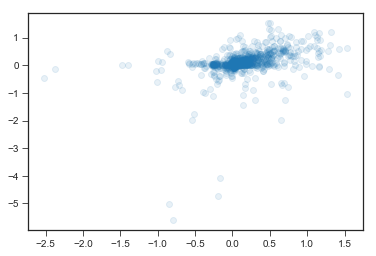

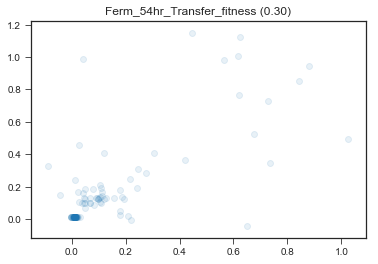

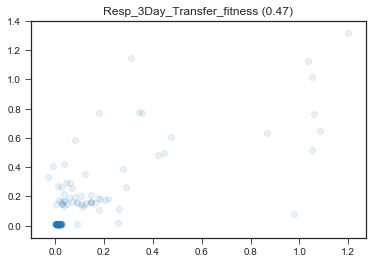

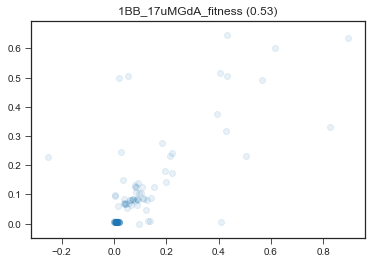

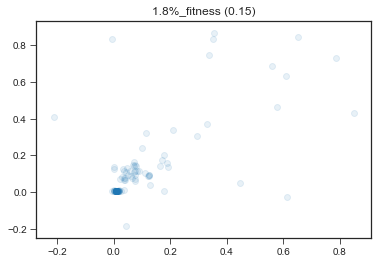

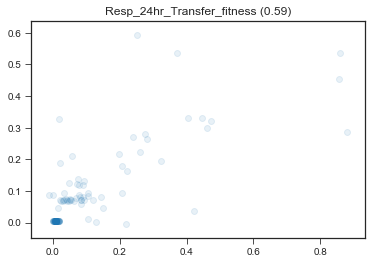

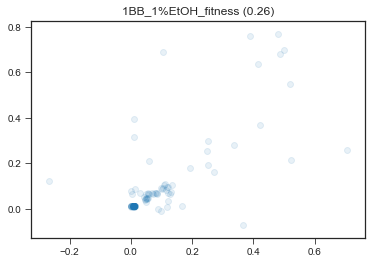

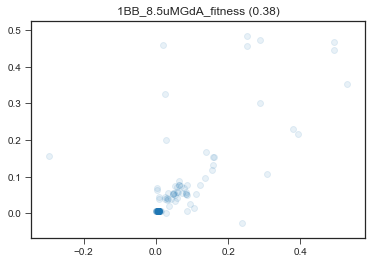

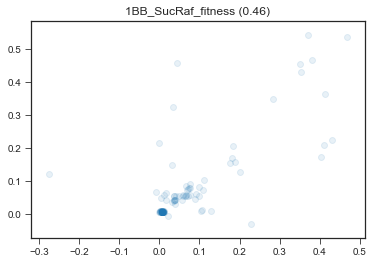

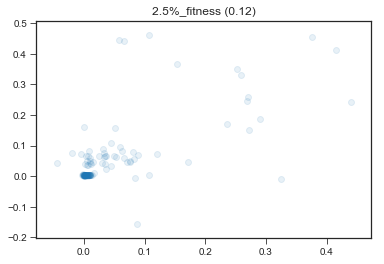

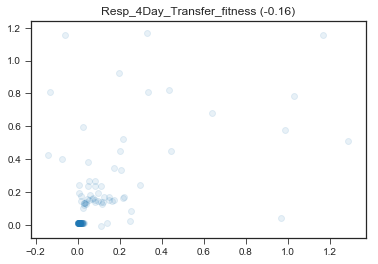

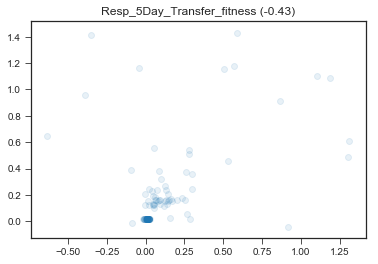

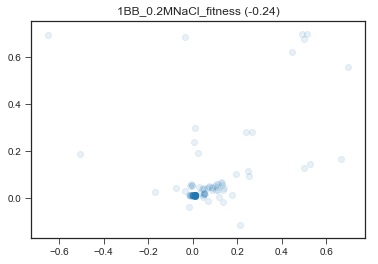

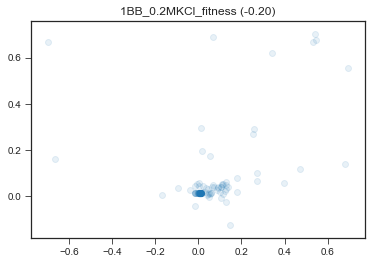

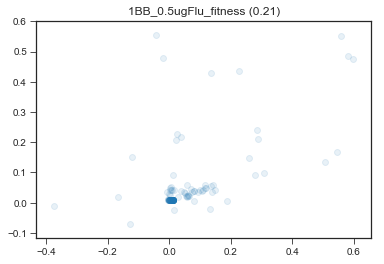

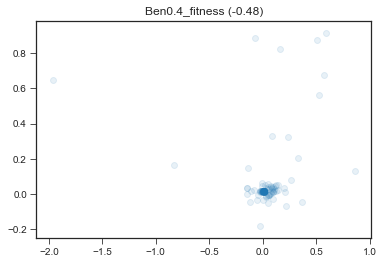

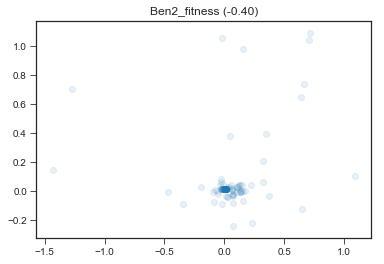

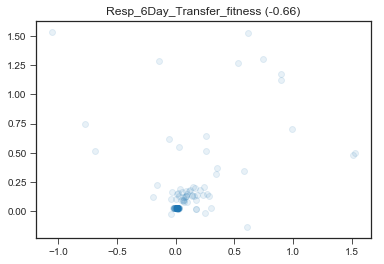

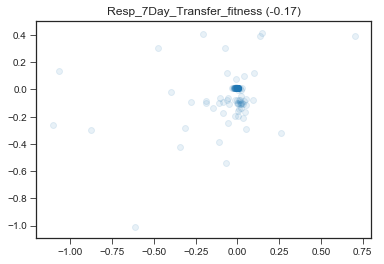

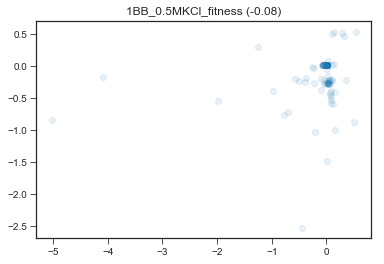

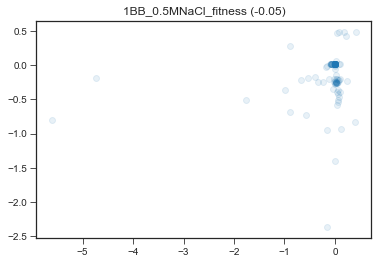

In [115]:
model = 2

truth = both_new
guess = test_count[:,:c_new[5][model].shape[1]]*c_new[5][model]

guess  = c_new[5][model]
truth = test_inv_count[:,:both_new.shape[1]]*both_new

plt.scatter(guess,truth,alpha=0.1)

for c in range(both_new.shape[1]):
    plt.figure()
    
    ve = tools.var_explained(truth[:,c],guess[:,c])[0]
    plt.title(f'{test_conditions[c]} ({ve:.2f})')
    plt.scatter(truth[:,c],guess[:,c],alpha=0.1)
    